In [12]:
import os
import sys
import random
import numpy as np
import torch

from torch import optim, nn
import torch.nn.functional as f

# functional
from functorch import make_functional, vmap, vjp, jvp, jacrev

import time
import json
import copy

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import matplotlib
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D

import time

In [13]:
# device
device_num = int(float('3'))
torch.cuda.set_device(device_num)
device = torch.device('cuda') \
    if torch.cuda.is_available() else torch.device('cpu')

## Positioning Encoding

$$
f(x; a, b) = \{1 \cdot \cos(x), \ldots, a_{10} \cdot \cos(2^{10} x), 1 \cdot \sin(x), \ldots, a_{10} \cdot \sin(2^{10} x)\}
$$


In [14]:
# function : position encoding 
input_encoder = lambda x, a, b: \
    torch.cat([a * torch.sin(x @ b.T), a * torch.cos(x @ b.T)], axis=-1)

'''
    Hyper-parameter for Position Encoding
'''
max_posenc_log_scale =  8#@param


include_basic = False #@param {type:"boolean"}
include_posenc = True #@param {type:"boolean"}

def get_abvals(include_basic, include_posenc, device='cpu'):
    # container
    enc_dict = {}

    if include_basic:
        bvals = torch.eye(3).to(device)
        avals = torch.ones((bvals.shape[0])).to(device)
        enc_dict['basic'] = (avals, bvals)

    if include_posenc:
        bvals = 2.**torch.arange(max_posenc_log_scale).to(device)
        bvals = (torch.eye(3, device=device)*bvals[:,None,None]).view(len(bvals)*3, 3).to(device)
        avals = torch.ones((bvals.shape[0])).to(device)
        enc_dict['posenc'] = (avals, bvals)

    else:
        NotImplementedError
        
    return enc_dict

## Neural Rendering

In [15]:
def get_rays(H, W, focal, c2w, device):
    '''
        args
            H : image height
            W : image width
            focal : focal length
            c2w : pose (4 x 4)    
    '''
    
    i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1).to(device)
    rays_d = torch.sum(torch.unsqueeze(dirs, -2) * c2w[:3,:3], -1) # rotate by pose
    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.shape) # origin set from pose
    result = torch.stack([rays_o, rays_d], 0) # stack
    return result

def render_rays(fnet, params, avals, bvals, rays, near, far, N_samples, rand=False, allret=False):
    # rays
    rays_o, rays_d = rays
    
    # Compute 3D query points
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device) 
    
    # chop a ray into multiple intervals
    if rand:
        shape = list(rays_o.shape[:-1]) + [N_samples]
        z_vals = z_vals[None, :] + (torch.rand(*shape, device=z_vals.device) * (far-near)/N_samples)
    
    # make rays
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = pts.view(-1,3)
    
    if avals != None:
        pts_flat = input_encoder(pts_flat, avals, bvals)
    
    raw = fnet(params, pts_flat)
    raw = raw.view(*(list(pts.shape[:-1]) + [4]))
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = f.relu(sigma_a)
    rgb = torch.sigmoid(rgb) 
    
    # Do volume rendering
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1], \
        torch.broadcast_to(torch.tensor([1e10], device=z_vals.device), z_vals[...,:1].shape)], -1) 
    alpha = 1. - torch.exp(-sigma_a * dists)
    trans = torch.minimum(torch.ones_like(alpha), (1. -alpha + 1e-10))
    trans = torch.cat([torch.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * torch.cumprod(trans, -1)
    rgb_map = torch.sum(weights[...,None] * rgb, -2) 
    acc_map = torch.sum(weights, -1)
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = torch.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(fnet, params, avals, bvals, rays, rand, allret):
    return render_rays(fnet, params, avals, bvals, rays, near=2., far=6., N_samples=N_samples, rand=rand, allret=allret)

def render_fn(fnet, params, avals, bvals, rays, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(fnet, params, avals, bvals, rays[:,i:i+chunk], rand, True)
        if i==0:
            rets = out
        else:
            rets = [torch.cat([a, b], 0) for a, b in zip(rets, out)]
    return rets

## Construction Networks

## Loss Function

In [16]:
def volume_render_loss(fnet, params, avals, bvals, rays, target, stratified, Verbose=False):
    rgb = render_fn_inner(fnet, params, avals, bvals, rays, stratified, False)    
    l = torch.pow((rgb - target), 2).mean()
    return l

def volume_render_loss(fnet, params, avals, bvals, rays, target, stratified, Verbose=False):
    rgb = render_fn_inner(fnet, params, avals, bvals, rays, stratified, False)
    # Verbose
    if True: 
        result = torch.pow((rgb - target), 2)
        
    l = torch.pow((rgb - target), 2).mean()
    return l

## Training

### Hyper-Parameters

In [17]:
lr =  5e-4#@param
batch_size = 1024 #@param
training_steps =  5000#@param
stratified_sampling = True #@param {type:"boolean"}

N_samples = 128 #@param
N_layers = 4
N_hidden = 256

embedding_size = 256 #@param

### Data Import

(7, 400, 400, 3) (13, 400, 400, 3) 555.5555155968841


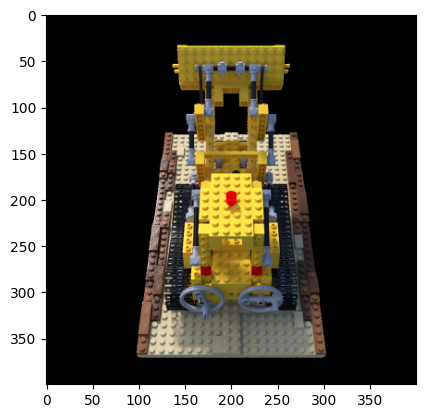

<Figure size 640x480 with 0 Axes>

In [18]:
# file
filename = './lego_400.npz'

data = np.load(filename)
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]

images, val_images, test_images = np.split(images[...,:3], [100,107], axis=0)
poses, val_poses, test_poses = np.split(poses, [100,107], axis=0)

# Test code
print(val_images.shape, test_images.shape, focal)
plt.imshow(test_images[0,...])
plt.show()
plt.clf()

# Import torch tensor
images = torch.Tensor(images).to(device)
val_images = torch.Tensor(val_images).to(device)
test_images = torch.Tensor(test_images).to(device)

poses = torch.Tensor(poses).to(device)
val_poses = torch.Tensor(val_poses).to(device)
test_poses = torch.Tensor(test_poses).to(device)

In [19]:
poses.shape, images.shape, focal

(torch.Size([100, 4, 4]), torch.Size([100, 400, 400, 3]), array(555.5555156))

In [20]:
poses[0]

tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
        [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
        [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:3')

In [21]:
'''
    Make training data
'''
training_rays = torch.stack([get_rays(H, W, focal, pose, device) for pose in poses], 1)
training_data = torch.cat([training_rays, images[None]]) # matching dimension (, num_pose, height, width)
training_data = torch.moveaxis(training_data, 0, -2) # flatten (num_poses and its )
training_data = training_data.view(-1, 3, 3)
training_data = training_data[torch.randperm(training_data.shape[0])]

### Networks

In [22]:
def make_network(num_layers, num_input, num_channels, num_outputs=1):
    # container
    layers = torch.nn.ModuleList()
    
    for i in range(num_layers-1):
        if i == 0:
            # MLP   
            layers.append(nn.Linear(num_input, num_channels))
        else:
            # MLP   
            layers.append(nn.Linear(num_channels, num_channels))
        
        # Activation
        layers.append(nn.ReLU())
        
    # Head layers
    layers.append(nn.Linear(num_channels, num_outputs))
    
    # model
    model = nn.Sequential(*layers)
    
    return model

In [24]:
'''
    Networks
'''
enc_dict = get_abvals(True, True, device=device)

# for all position encoding version
models_dict = {"model_{}".format(name) : \
    make_functional(make_network(N_layers, value[1].shape[0]*2, N_hidden, 4).to(device)) for name, value in enc_dict.items()}

# add no position encoding version
models_dict.update({"no_encoding" 
                    : make_functional(make_network(N_layers, 3, N_hidden, 4).to(device))})

/home/mgyukim/.conda/envs/Llama/lib/python3.10/site-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


### Run Training

In [25]:
def train_model(fnet, params, lr, iters, avals, bvals, stratified, training_data, batch_size, name='', plot_groups=None, plotlosses_model=None):
    
    if bvals is not None:
        init_shape = (-1, bvals.shape[0]*2)
    else:
        init_shape = (-1, 3)
    
    # optimizer
    opt = optim.Adam(params, lr=lr)
    

    if plot_groups is not None:
        plot_groups['PSNR'].append(f'{name}')
    
    
    # declare indices
    b_i = 0
    xs = []
    psnrs = []
    t = time.time()
    t0 = t
    
    for i in range(iters+1):
        # initialization grad
        opt.zero_grad()
        
        # construct trainig dataset
        batch = training_data[b_i:b_i+batch_size]
        b_i += batch_size
        rays = torch.moveaxis(batch[:,:2], 1, 0) # 0 : ray_o, 1: ray_d
        target = batch[:,2] # rgb : images 
        if b_i >= training_data.shape[0]:
            b_i = 0
            
        # loss
        loss = volume_render_loss(fnet, params, avals, bvals, rays, target, stratified)
        
        # update params
            # compute grad
        loss.requires_grad_(True)  
        loss.backward()
      
        # update
        opt.step()
        
        # new params
        params = opt.param_groups[-1]['params']
        
        if i%100==0:
            print("training loss : ", loss.item())
        
        
        # validation codes
        if i%1000==0 or i==iters:
            with torch.no_grad():
                psnr = []
                print(i, (time.time() - t) / 200, 'secs per iter', (time.time()-t0)/60., 'total mins')
                num_vals = val_poses.shape[0] if i==iters else 1
                for v in range(num_vals):
                    # make rays for rendering the holdout view for logging
                    rays = get_rays(H, W, focal, val_poses[v,...], device=val_poses.device)
                
                    # rendering by nets
                    rgb, depth, acc = render_fn(fnet, params, avals, bvals, rays, False)
                
                    # val loss
                    val_loss = torch.pow((rgb - val_images[v,...]), 2).mean()
                    psnr.append(-10. * torch.log10(val_loss).item())
                psnr = np.mean(np.array(psnr))
                print("val loss : ", val_loss.item())
                psnrs.append(psnr)
                xs.append(i)
                
            if plot_groups is not None:
                assert plotlosses_model is not None, "plotlosses_model is None"
                plotlosses_model.update({f'{name}':psnr}, current_step=i)
                plotlosses_model.send()
            t = time.time()
            
    results = {
        'state': opt.param_groups[-1]['params'],
        'psnrs': psnrs,
        'avals': avals,
        'bvals': bvals,
        'val_image': rgb,
        'xs': xs
    }
    return results

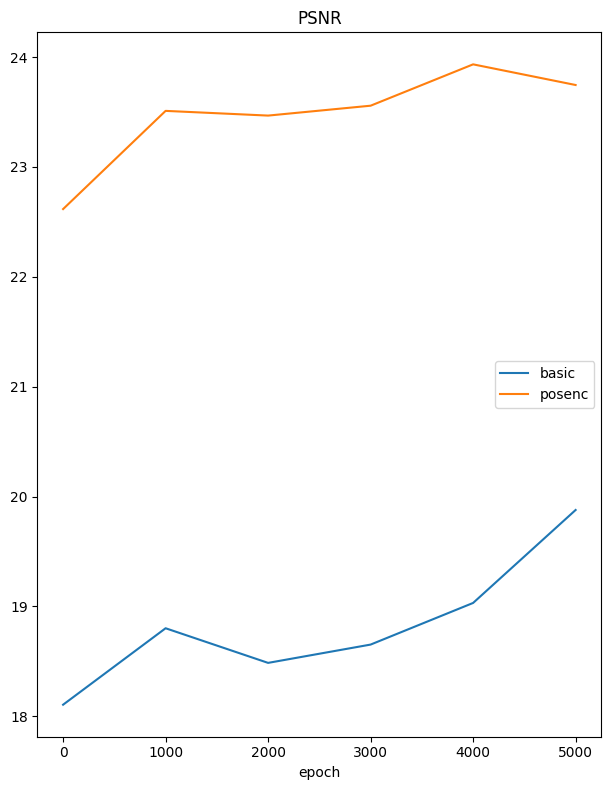

PSNR
	basic            	 (min:   18.105, max:   19.877, cur:   19.877)
	posenc           	 (min:   22.617, max:   23.934, cur:   23.746)


In [29]:
plt_groups = {'PSNR':[]}
outputs = {}
plotlosses_model = PlotLosses(groups=plt_groups)

for k in tqdm(enc_dict, leave=False):
    outputs[k] = train_model(
        fnet = models_dict["model_{}".format(k)][0], 
        params = models_dict["model_{}".format(k)][1],
        lr = lr,
        iters = training_steps, 
        avals = enc_dict[k][0], 
        bvals = enc_dict[k][1], 
        stratified = stratified_sampling, 
        training_data = training_data,
        batch_size = batch_size,
        name=k,
        plot_groups=plt_groups,
        plotlosses_model=plotlosses_model)

### Decoration

----------------------------------------
           Bar Chart           
----------------------------------------


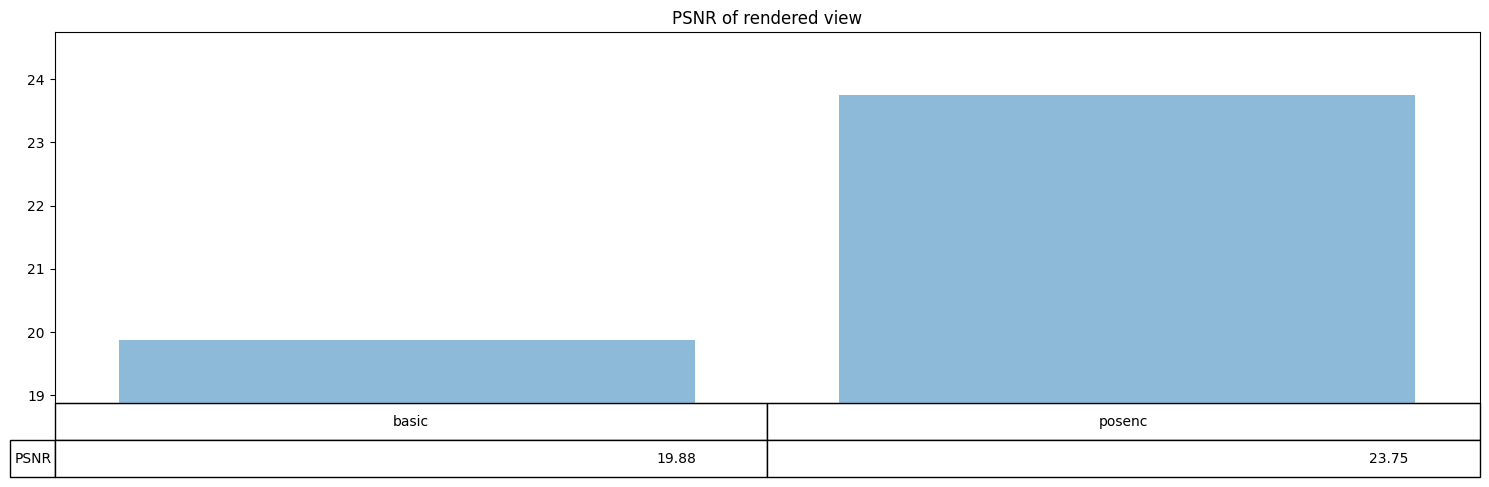

----------------------------------------
           Test           
----------------------------------------


<Figure size 640x480 with 0 Axes>

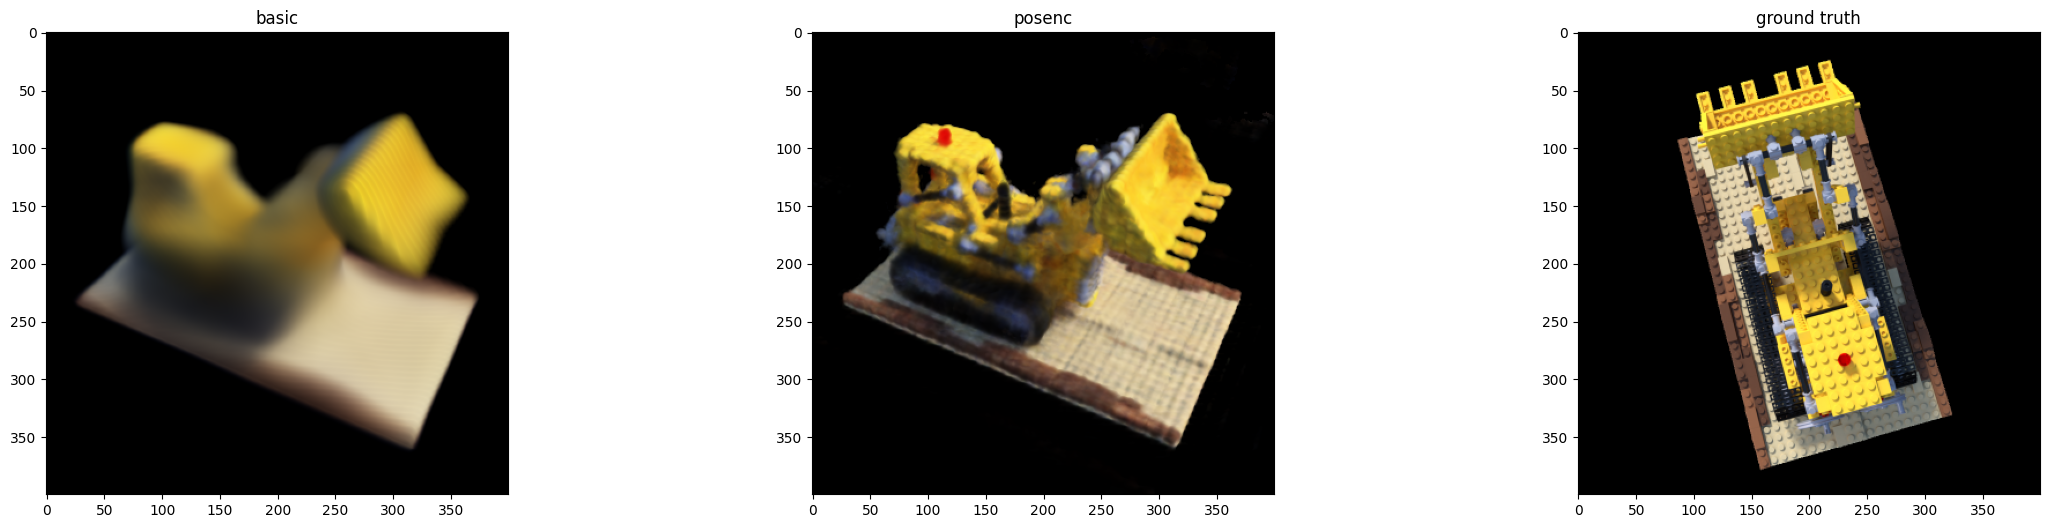

<Figure size 640x480 with 0 Axes>

In [30]:
bar_graph = True 
renders_viz = True 


names = list(outputs.keys())
xvals = np.arange(len(names))
test_value = np.array([outputs[n]['psnrs'][-1] for n in names])
inds = np.argsort(test_value)
names_sort = [names[i] for i in inds]

if bar_graph:
    print('----------------------------------------')
    print(' '*10, 'Bar Chart', ' '*10)
    print('----------------------------------------')
    plt.figure(figsize=(15,5))
    plt.bar(xvals, test_value[inds], alpha=.5)
    # plt.xticks(xvals, names_sort, rotation=60)
    plt.xticks([])
    plt.ylim(test_value.min()-1, test_value.max()+1)
    plt.title(f'PSNR of rendered view')
    plt.table(cellText=[['%.2f' % x for x in test_value[inds].tolist()]],
        rowLabels=['PSNR'],
        colLabels=names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])
    plt.tight_layout()
    plt.show()
    plt.clf()

if renders_viz:
    print('----------------------------------------')
    print(' '*10, 'Test', ' '*10)
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(outputs[p]['val_image'].detach().cpu().numpy())
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(val_images.detach().cpu().numpy()[0])
    plt.title('ground truth')
    plt.show()
    plt.clf()